Loads DEM, coherence maps. <br>
Select pixels based on the following criteria:
1. in a certain elevation range (not too low = in LS, not too high = affected by atm noise)
2. spent X fraction of time spent above X threshold coherence value.
3. above threshold of average coherence (temporal)
4. below threshold of coherence standard deviation (temporal)

Current thresholds: 
1. Between -20 and 75 m elevation
2. Spends 80% of time with coherence above 0.8
3. has avg coherence above 0.88
4. has coherence std below 0.1

In [2]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM.

In [3]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)

print('DEM loaded.')

DEM loaded.


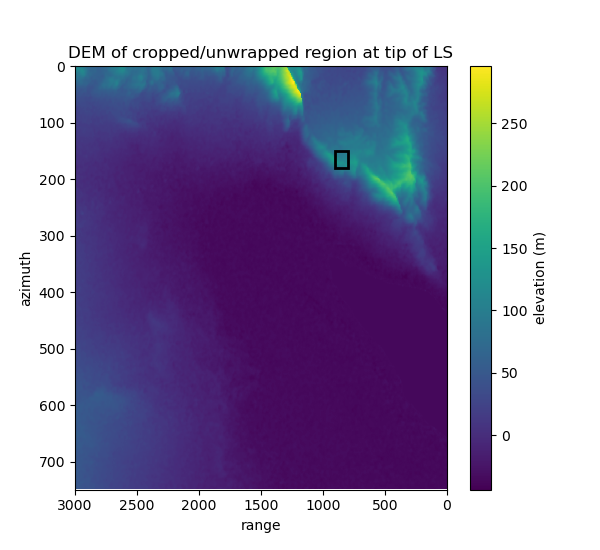

In [4]:
# Extract subregion that was unwrapped full res and plot it. 
box = np.zeros((5,2))
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]
plt.figure(figsize=(6,5.5))
plt.imshow(elev_cropped, cmap='viridis',aspect='auto',interpolation='nearest')
plt.xlim(x1-x2, 0)
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('DEM of cropped/unwrapped region at tip of LS')
plt.colorbar(label='elevation (m)')
plt.show()

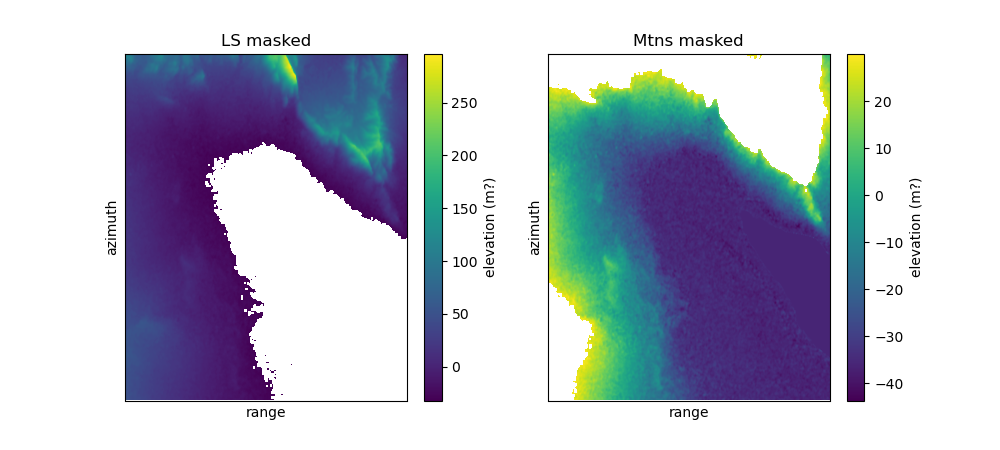

In [5]:
elev_masked_LS = np.ma.masked_where(elev_cropped<-32,elev_cropped)
elev_masked_mtns = np.ma.masked_where(elev_cropped>30,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_masked_LS, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS masked'); plt.colorbar(label='elevation (m?)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_mtns, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mtns masked'); plt.colorbar(label='elevation (m?)')
plt.show()

Load coherence maps.

In [5]:
saveDir = '/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/'
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Calculate how much time each pixel has spend above threshold value. 

In [6]:
# set threshold values 
th_coh  = 0.8
th_time = 0.8  # 80% of the time 

time_above_th = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        coh_temp = coh[:,y,x]
        time_above_th[y,x] = (coh_temp>=th_coh).sum()
time_above_th = time_above_th/numIgrams # converts to percentage of dates 
print('Num dates above '+str(th_coh)+' coh threshold calculated.')

Num dates above 0.8 coh threshold calculated.


Now calculate coherence standard deviation and mean for each pixel over time.

In [7]:
# initialize arrays for means and stds
coh_mean = np.ndarray((dy,dx),dtype='float')
coh_std = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        coh_temp = coh[:,y,x]
        coh_mean[y,x] = np.median(coh_temp)
        coh_std[y,x] = np.std(coh_temp)
print('Coh means and standard deviations calculated.')

Coh means and standard deviations calculated.


Now mask based on ALL the criteria above. Iterate over variables to be masked.

In [8]:
elev_min = -20
elev_max = 75
elev_masked = np.ma.masked_where(elev_cropped<elev_min,elev_cropped)
elev_masked = np.ma.masked_where(elev_masked>elev_max,elev_masked)

coh_time_masked = np.ma.masked_where(time_above_th<th_time,time_above_th)

th_coh_mean = 0.88
coh_mean_masked = np.ma.masked_where(coh_mean<th_coh_mean,coh_mean)

th_coh_std = 0.1
coh_std_masked = np.ma.masked_where(coh_std>th_coh_std,coh_std)

Plot them.

In [1]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.imshow(elev_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('elevations between 0-50 m'); plt.colorbar(label='elevation (m?)')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(2,2,2)
plt.imshow(coh_time_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
label_cbar = str('fraction of time spent above '+str(th_coh)+' coh')
title_text = str('pixels that spend >'+str(th_time*100)+'% of time with >'+str(th_coh)+' coherence')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label=label_cbar)
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(2,2,3)
plt.imshow(coh_mean_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with avg coh >'+str(th_coh_mean))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='avg temporal coherence')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(2,2,4)
plt.imshow(coh_std_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with std coh <'+str(th_coh_std))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='coherence std')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.show()

NameError: name 'plt' is not defined

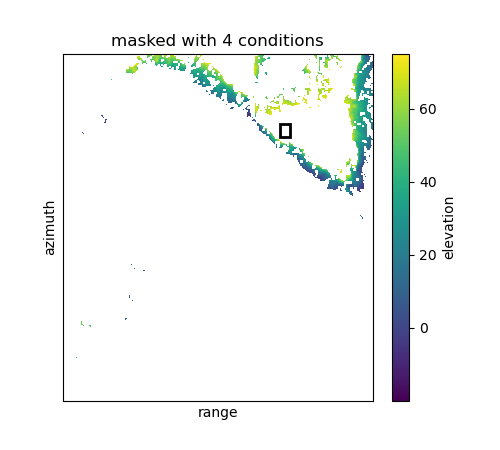

Number of reference pixels based on threshold criteria:
199351


In [33]:
elev_min = -20
elev_max = 75

masked = np.ma.masked_where(elev_cropped<elev_min,elev_cropped)
masked = np.ma.masked_where(masked>elev_max,masked)
masked = np.ma.masked_where(time_above_th<th_time,masked)
masked = np.ma.masked_where(coh_mean<th_coh_mean,masked)
masked = np.ma.masked_where(coh_std>th_coh_std,masked)

plt.figure(figsize=(5,4.5))
plt.imshow(masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('masked with 4 conditions'); plt.colorbar(label='elevation')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.show()

num_ref_pix = (masked>-1000).sum()
print('Number of reference pixels based on threshold criteria:\n'+str(num_ref_pix))

Try using this combined mask to display coherence values for single igram, but masked based on above conditions.

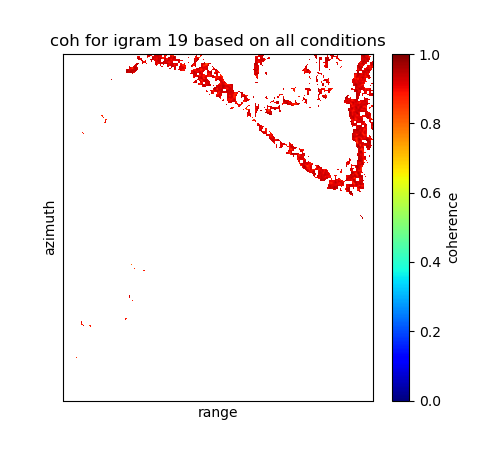

Avg coh value of ref pixels: 0.9050554611079332


In [34]:
k=19
mask_test = np.ma.masked_where(masked<-1000,coh[k])

plt.figure(figsize=(5,4.5))
plt.imshow(mask_test, cmap='jet',aspect='auto',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('coh for igram '+str(k)+' based on all conditions') 
plt.colorbar(label='coherence'); plt.show()

masked_y,masked_x = np.nonzero(masked)
ref_pix_coh_mean = np.mean(coh[k,masked_y,masked_x])
print('Avg coh value of ref pixels: '+str(ref_pix_coh_mean))

Make an array with 1's and 0's to represent the mask.

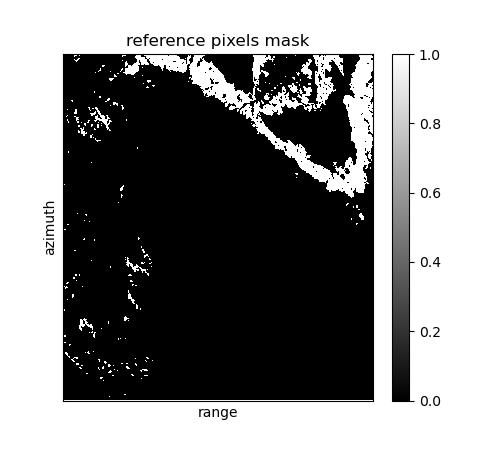

In [38]:
ref_mask = np.zeros((dy,dx))
ref_mask[masked_y,masked_x] = 1.0

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

Now save the mask file.

In [40]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
saveDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
save_file_name = 'ref_pixels_mask.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(ref_mask)
colds=None
print('Mask of reference pixels saved.')

Mask of reference pixels saved.
